## Моделирование случайного поля

Типичный пример, где могут быть нужны случайные поля - хотим смоделировать 100 реализаций некоторого процесса (например, теплопроводности), для разных начальных условий. Откуда взять разнообразные начальные условия? Случайно задавать в каждой точке нехорошо, поскольку в реальных ситуациях распределение по пространству обычно обладает определенной гладкостью. За гладкость отвечает корреляционная функция. Так мы приходим к задаче моделирования случайного поля с заданной корреляционной функцей. 

Итак, для определенности, хотим задать случайное и (для простоты) изотропное поле $U(x, y)$ на плоскости $x, y$. Физически можно представлять, что $U$ задает распределение некоторого свойста среды, например температуры. Условие изотропности означает, что корреляция значений $U$ в двух различных точках зависит только от расстояния $r$ между этими точками. Зададим конктретный вид корреляционной функции $K(r, a)$. Параметр $a$ отвечает за характерный масштаб корреляции:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

def K(r, a=1):
    return np.exp(-r/a)

Будем моделировать поле U в квадратной области размера 50х50:

In [3]:
shape = (50, 50)

Составим матрицу $D$, в которой содержатся все попарные расстояния для точек нашей области (матрица получится размера $50^2\times50^2$):

In [4]:
points = np.moveaxis(np.indices(shape), 0, -1).reshape(-1, 2).astype(np.float32)
D = np.linalg.norm(points.reshape(1, -1, 2) - points.reshape(-1, 1, 2), axis=-1)
D.shape

(2500, 2500)

Теперь применим функцию K к каждому элементу матрицы D и получим матрицу корреляций для точек нашей области:

In [4]:
B = K(D, a=1000)

Найдем разложение матрицы $B$ в виде $B = AA^T$

In [5]:
A = np.linalg.cholesky(B)

Можно проверить, что $AA^T=B$:

In [6]:
np.isclose(A@A.T, B)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Теперь, чтобы смодледировать вектор $\xi\sim N(0, B))$, нужно взять $\eta\sim N(0, I)$ (т.е. вектор из n независимых N(0,1) величин) и применить к нему преобразование A, т.е. $\xi=A\eta$:

In [4]:
@interact(correlation_scale=(1, 1000), n=(50, 200))
def plot_fields(correlation_scale=1000, n=150):
    shape = (n, n)
    points = np.moveaxis(np.indices(shape), 0, -1).reshape(-1, 2).astype(np.float32)
    D = np.linalg.norm(points.reshape(1, -1, 2) - points.reshape(-1, 1, 2), axis=-1)
    B = K(D, a=correlation_scale)
    A = np.linalg.cholesky(B)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(len(ax)):
        normals = np.random.randn(np.prod(shape))
        u = (A @ normals).reshape(shape)
        ax[i].imshow(u, cmap='PuOr')

interactive(children=(IntSlider(value=1000, description='correlation_scale', max=1000, min=1), IntSlider(value…

Чем меньше масштаб корреляции, тем в более близких точках значения поля становятся независимыми.

Немного модифицируем задачу. Пусть теперь значения поля U в некоторых точках будут заданы (например, мы провели прямые измерения) и хотим восстановить поле U в остальных точках.

Зададим массив точек, в которых значения U будут фиксированы

In [5]:
# given_points = np.array([[i, j] for i in range(1, 50) for j in range(1, 50) if abs((i - 25) ** 2 + (j - 25) ** 2 - 36) <= 10])
given_points = np.array([[i, j] for i in range (1, 50) for j in range(20, 30)])
given_points

array([[ 1, 20],
       [ 1, 21],
       [ 1, 22],
       [ 1, 23],
       [ 1, 24],
       [ 1, 25],
       [ 1, 26],
       [ 1, 27],
       [ 1, 28],
       [ 1, 29],
       [ 2, 20],
       [ 2, 21],
       [ 2, 22],
       [ 2, 23],
       [ 2, 24],
       [ 2, 25],
       [ 2, 26],
       [ 2, 27],
       [ 2, 28],
       [ 2, 29],
       [ 3, 20],
       [ 3, 21],
       [ 3, 22],
       [ 3, 23],
       [ 3, 24],
       [ 3, 25],
       [ 3, 26],
       [ 3, 27],
       [ 3, 28],
       [ 3, 29],
       [ 4, 20],
       [ 4, 21],
       [ 4, 22],
       [ 4, 23],
       [ 4, 24],
       [ 4, 25],
       [ 4, 26],
       [ 4, 27],
       [ 4, 28],
       [ 4, 29],
       [ 5, 20],
       [ 5, 21],
       [ 5, 22],
       [ 5, 23],
       [ 5, 24],
       [ 5, 25],
       [ 5, 26],
       [ 5, 27],
       [ 5, 28],
       [ 5, 29],
       [ 6, 20],
       [ 6, 21],
       [ 6, 22],
       [ 6, 23],
       [ 6, 24],
       [ 6, 25],
       [ 6, 26],
       [ 6, 27],
       [ 6, 28

Зададим значения поля U в этих точках:

In [9]:
from PIL import Image, ImageOps

def get_grayscale_image_arr(path):
    img_array = np.array(ImageOps.grayscale(Image.open(path))).astype(int)
    img_array[img_array != 255] = 0
    return img_array.astype(bool).astype(int)

In [46]:
given_points = np.where(get_grayscale_image_arr('./imgs/input/0001.png') == 0)
given_points = list(zip(given_points[0], given_points[1]))
given_points = np.array([list(x) for x in given_points])
given_points

array([[ 24, 277],
       [ 24, 278],
       [ 24, 279],
       ...,
       [171, 278],
       [171, 279],
       [172, 277]], dtype=int64)

In [47]:
given_values = np.zeros(len(given_points)) - 2
given_values

array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2

Изобразим данные нам точки и значения на карте:

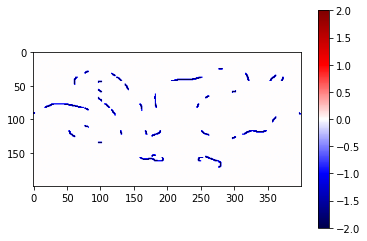

In [50]:
shape=(200, 400)
points = np.moveaxis(np.indices(shape), 0, -1).reshape(-1, 2).astype(np.float32)

u = np.zeros(shape)
u[given_points[:, 0], given_points[:, 1]] = given_values
plt.imshow(u, cmap='seismic', vmin=-2, vmax=2)
plt.colorbar()

Следующий шаг - смодилировать несколько реализаций поля U вокруг заданных точек и значений. Идея в том, что если поле U является гауссовским, т.е. совместное распределение значений поля $u_1, ..., u_n$ в точках $x_1, ..., x_n$ -- гауссовское:
$$p(u_1, ..., u_n) = N(0, \Sigma),$$
то условные распределения тоже будут гауссовскими:
$$p(u_1, ..., u_k | u_{k+1}, ...,  u_n) = N(\mu, \tilde\Sigma).$$
Можно выписать конкретную формулу:

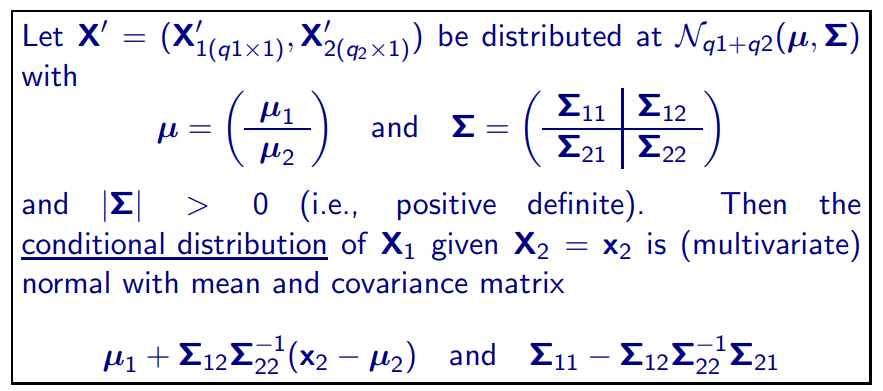

Код ниже реализует эту идею и сэмплирует 3 случайные реализации из условного распределения:

In [55]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

gp = GaussianProcessRegressor(RBF(4, length_scale_bounds='fixed'))
gp.fit(given_points, given_values)

plt.figure(figsize=(15, 5))
predicted = gp.sample_y(points, n_samples=1)
plt.imshow(predicted[..., i].reshape(shape), vmin=-2, vmax=2, cmap='PuOr')

MemoryError: Unable to allocate 23.8 GiB for an array with shape (3199960000,) and data type float64

<Figure size 1080x360 with 0 Axes>

In [ ]:
def plot_gpr():
    given_points = np.array([[i, j] for i in range(1, 50) for j in range(1, 50) if abs((i - 25) ** 2 + (j - 25) ** 2 - 36) <= 10])
    given_values = np.zeros(len(given_points)) - 2
    
    gp = GaussianProcessRegressor(RBF(4, length_scale_bounds='fixed'))
    gp.fit(given_points, given_values)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    predicted = gp.sample_y(points, n_samples=len(ax))
    for i in range(len(ax)):
        ax[i].imshow(predicted[..., i].reshape(shape), vmin=-2, vmax=2, cmap='seismic')

Обратите внимание, что на всех картинках значения в точках given_points совпадает с теми значениями given_values, которые мы сами задали. Это можно проверить и непосредственно, например, возьмем значения в точках given_points из самой левой картинки:

In [21]:
predicted[..., 0].reshape(shape)[given_points[:, 0], given_points[:, 1]]

array([ 0.45367773,  1.83887354, -1.17439593, -1.73091697, -0.91685328,
        1.13485395,  1.6804039 , -1.34613208,  0.96251582,  0.12927732,
        1.00268343, -1.78521928, -1.73687368,  0.11679371, -0.46602484,
        1.60294162])

и увидим, что они совпадают (почти, небольшая разница объяснима деталями реализации рауссовской регрессии) с исходными given_values:

In [22]:
given_values

array([ 0.45368438,  1.83887715, -1.17439297, -1.7309098 , -0.91686909,
        1.13484801,  1.68040864, -1.34613204,  0.96251232,  0.12927931,
        1.00267842, -1.78522615, -1.73687419,  0.11678197, -0.46602585,
        1.60295123])

Если рассматривать не случайные реализации U, а среднее по большому числу реализаций, то результат регрессии будет как на картинке ниже:

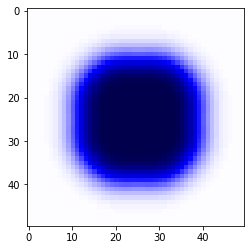

In [12]:
mean = gp.predict(points).reshape(shape)
plt.imshow(mean, vmin=-2, vmax=2, cmap='seismic')

Упражнение: проверьте, как параметр ядра RBF(4, length_scale_bounds='fixed') влияет на результат регрессии.

Дальше разберем домашнюю задачу, в которой для гауссовского распределения с ковариационной матрицей [[40, -2], [-2, 17]] нужно было найти представление в виде линейной комбинации независимых нормальных величин.

Такое представление не единственно и ниже приведено три разных способа решения:

In [ ]:
S = np.array([[40, -2], [-2, 17]])

Вариант 1: угадать

In [ ]:
a = np.array([[2, 6], [-4, 1]])
a@a.T

array([[40, -2],
       [-2, 17]])

Вариант 2: разложение Холецкого 

In [ ]:
b = np.linalg.cholesky(S)
b@b.T

array([[40., -2.],
       [-2., 17.]])

Вариант 3: SVD разложение

In [ ]:
v, d, w = np.linalg.svd(S)
v@np.diag(d)@w.T

array([[40., -2.],
       [-2., 17.]])

Все три варианта приводят к одному и тому же распределению:

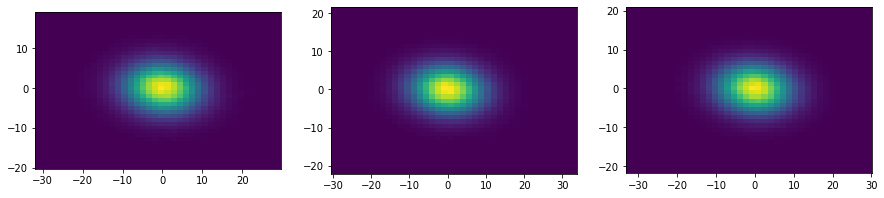

In [ ]:
normals = np.random.randn(2, 1000000)

fig, ax = plt.subplots(1, 3, figsize=(15, 7))
fig.patch.set_facecolor('xkcd:white')

samples = a @ normals
ax[0].hist2d(*samples, bins=40)
ax[0].set_aspect('equal')

samples = b @ normals
ax[1].hist2d(*samples, bins=40)
ax[1].set_aspect('equal')

samples = v @ np.diag(np.sqrt(d)) @ normals
ax[2].hist2d(*samples, bins=40)
ax[2].set_aspect('equal')
plt.show()

Теперь нарисуем эллипсы, содержащие 50%, 95% и 99% плотности. 

Предварительно находим собственные значения и вектора для ковариационной матрицы

In [ ]:
eig_vals, eig_vecs = np.linalg.eig(S)
print('Eigenvals', eig_vals)
print('Eigenvecs', eig_vecs[:, 0], eig_vecs[:, 1])

Eigenvals [40.17261753 16.82738247]
Eigenvecs [ 0.99629608 -0.08598908] [0.08598908 0.99629608]


Дальше нам потребуются квантили хи-квадрат распредедения. Например, квантиль уровня 0.95 для хи-квадрат распределения с двумя степенями свободы

In [ ]:
import scipy.stats as stats

stats.chi2.ppf(0.95, 2)

5.991464547107979

Теперь можно рисовать эллипсы. На картинке ниже построены эллипсы для 50%, 95%  и 99% вероятности: 

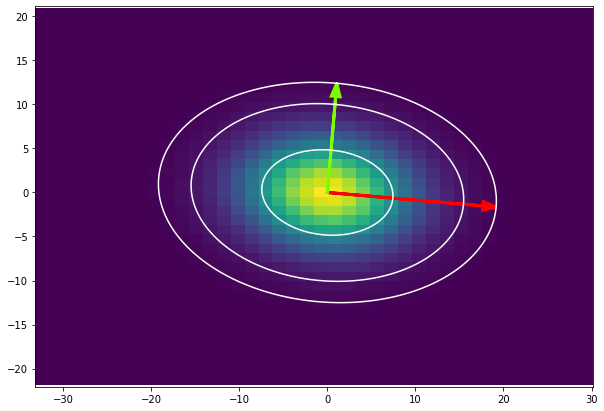

In [ ]:
t = np.linspace(0, 2*np.pi, 1000);
ellipsis = eig_vecs @ np.diag(np.sqrt(eig_vals)) @ np.array([np.sin(t), np.cos(t)])

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.patch.set_facecolor('xkcd:white')
plt.hist2d(*samples, bins=40, density=True)

for p in [0.5, 0.95, 0.99]:
    q = stats.chi2.ppf(p, 2)
    plt.plot(*(np.sqrt(q) * ellipsis), c='w')

plt.arrow(0, 0, *eig_vecs[:, 0]*np.sqrt(eig_vals[0])*np.sqrt(q), 
          color='r', head_width=1, lw=3, length_includes_head=True)
plt.arrow(0, 0, *eig_vecs[:, 1]*np.sqrt(eig_vals[1])*np.sqrt(q),
          color='#7CFC00', head_width=1, lw=3, length_includes_head=True)

plt.axis('equal')
plt.show()

Продолжение следует...